# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/pyNBA/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Data Analysis
Summarize the characteristics of the dataset.

In [2]:
query_data = QueryData()
clean_data = CleanData()
helpers = Helpers()

# pull boxscore data
boxscores = query_data.query_boxscore_data()
boxscores = clean_data.select_regular_season_games(boxscores)

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


,GAMEID,PLAYERID,DATE,TEAM,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,0021400001,2422,2014-10-28,NOP,ORL,,0,572,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1,0.071,1.0,0.100,1,0.100,100.0,0,0,0,3,10,0.000,100.77,0021400001,2014-15,NOP,ORL,ORL,2422,John Salmons,Forward-Guard,Miami (FL),USA,78,210,2002,1,26,1979-12-12
1,0021400001,201569,2014-10-28,NOP,ORL,,1,1891,8,3,8,1,2,1,3,5,0,2,4,0.5,1.0,0,0.000,4.0,0.111,0,0.000,0.0,2,2,3,1,17,0.152,95.19,0021400001,2014-15,NOP,ORL,ORL,201569,Eric Gordon,Guard,Indiana,USA,75,215,2008,1,7,1988-12-25
2,0021400003,203477,2014-10-28,HOU,LAL,,0,427,2,0,1,0,1,2,2,0,2,0,0,0.0,0.0,0,0.000,1.0,0.143,0,0.000,0.0,0,0,1,0,-8,0.176,101.17,0021400003,2014-15,LAL,HOU,HOU,203477,Isaiah Canaan,Guard,Murray State,USA,72,200,2013,2,34,1991-05-21
3,0021400002,2734,2014-10-28,DAL,SAS,,0,1747,17,6,12,2,5,3,4,2,0,3,2,0.0,0.5,0,0.000,0.0,0.000,5,0.278,25.0,2,0,1,1,-2,0.263,86.55,0021400002,2014-15,SAS,DAL,DAL,2734,Devin Harris,Guard,Wisconsin,USA,75,185,2004,1,5,1983-02-27
4,0021400003,202391,2014-10-28,LAL,HOU,,1,1748,7,1,5,0,1,5,6,0,0,0,2,0.0,0.0,1,0.033,1.0,0.033,6,0.333,35.3,0,0,4,3,-17,0.162,97.21,0021400003,2014-15,LAL,HOU,HOU,202391,Jeremy Lin,Guard,Harvard,USA,75,200,-1,-1,-1,1988-08-23


In [3]:
q_boxscores = query_data.query_quarterly_boxscore_data()
q_boxscores = q_boxscores.pivot_table('SECONDSPLAYED', ['GAMEID', 'PLAYERID'], 'QUARTER')
q_boxscores.columns =['SP(Q{})'.format(str(col)) for col in q_boxscores.columns]

In [4]:
boxscores = boxscores.merge(q_boxscores, on=['GAMEID', 'PLAYERID'], how='left')
boxscores[q_boxscores.columns] = boxscores[q_boxscores.columns].fillna(0)

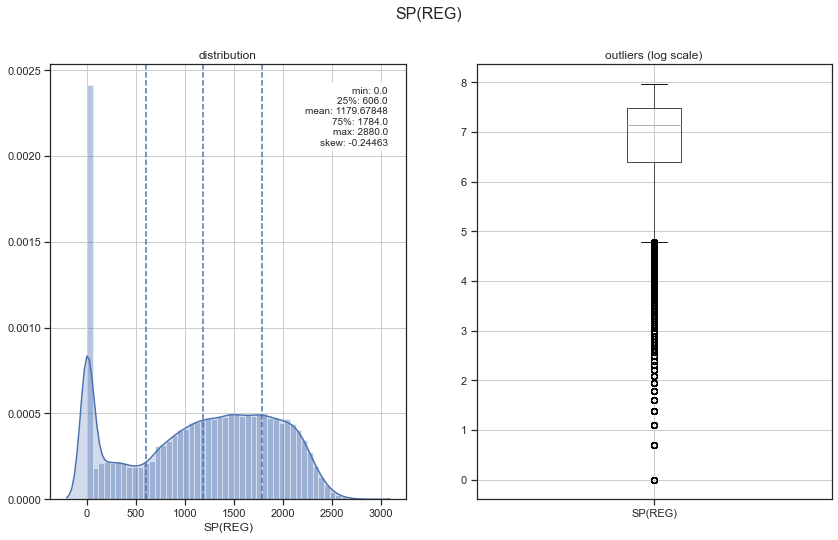

In [5]:
boxscores['SP(REG)'] = boxscores['SP(Q1)'] + boxscores['SP(Q2)'] + boxscores['SP(Q3)'] + boxscores['SP(Q4)']
helpers.visualize_variable_distribution(boxscores, 'SP(REG)', figsize=(14, 8))

# Feature Engineering
Create new features from raw data using domain knowlege.

In [6]:
y = 'SP(REG)'
regressors = []

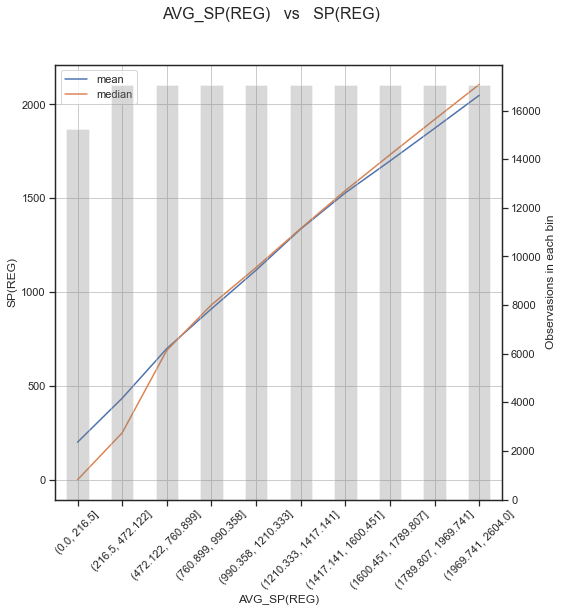

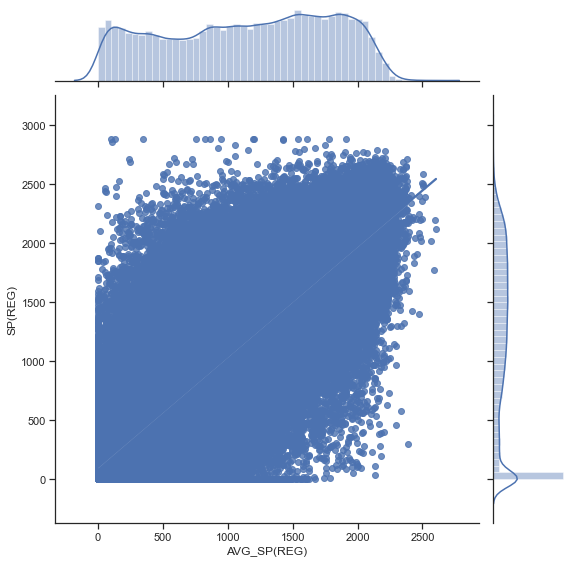

In [7]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name='AVG_SP(REG)'
)
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_SP(REG)', 'SP(REG)', figsize=(8, 8))
regressors.append('AVG_SP(REG)')

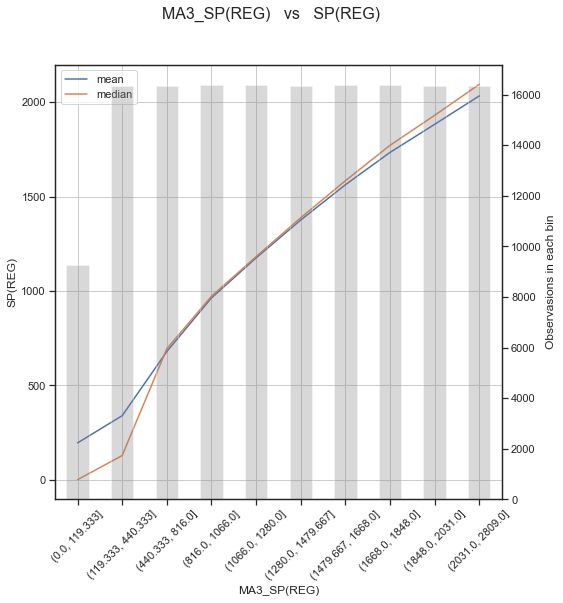

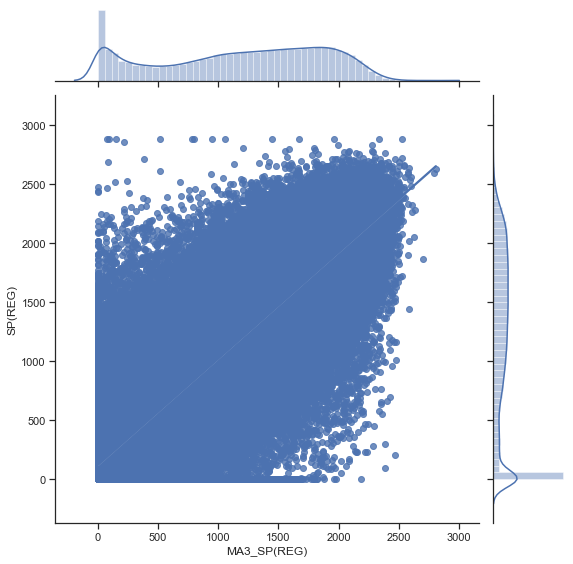

In [8]:
boxscores = feature_creation.rolling_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SP(REG)', new_col_name='MA3_SP(REG)',
    n_rolling=3, min_periods=2
)
helpers.visualize_numeric_x_vs_y(boxscores, 'MA3_SP(REG)', 'SP(REG)', figsize=(8, 8))
regressors.append('MA3_SP(REG)')

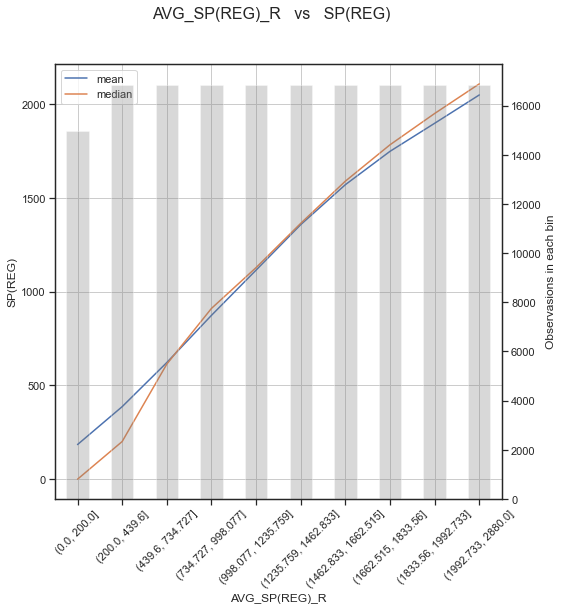

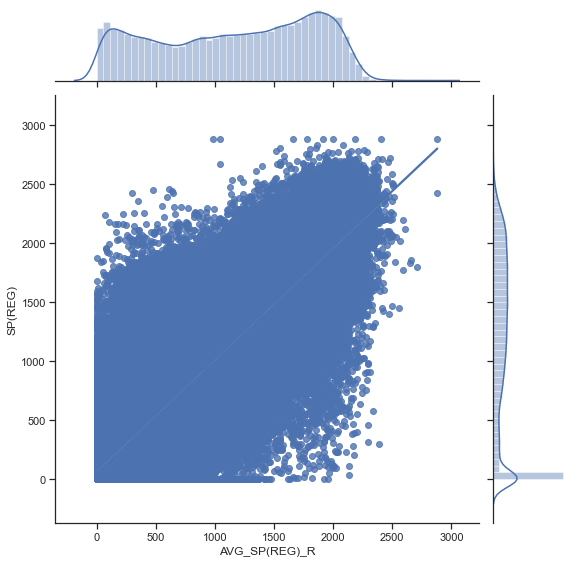

In [9]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name='SP(REG)', new_col_name='AVG_SP(REG)_R'
)
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_SP(REG)_R', 'SP(REG)', figsize=(8, 8))
regressors.append('START')
regressors.append('AVG_SP(REG)_R')

In [10]:
temp = boxscores.dropna(subset=['AVG_SP(REG)'])
temp = temp.groupby(['GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'SUM_AVG_SP(REG)': x['AVG_SP(REG)'].sum()
    })
)
boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')
regressors.append('SUM_AVG_SP(REG)')

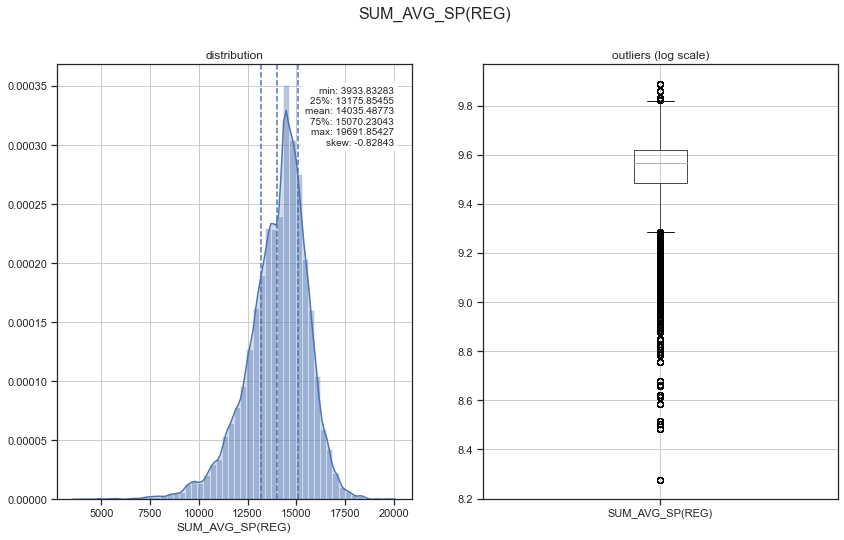

In [11]:
helpers.visualize_variable_distribution(boxscores, 'SUM_AVG_SP(REG)', figsize=(14, 8))

### Blowout Risk
Next, I will create features that capture the blowout risk in a game.

In [12]:
odds = query_data.query_odds_data()
odds['POINTSPREAD'] = odds['POINTSPREAD'].replace(['PK', '-'], 0)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [13]:
boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')
regressors.append('POINTSPREAD')

### Weights
TODO

In [14]:
w = 'WEIGHT'
boxscores[w] = 1

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

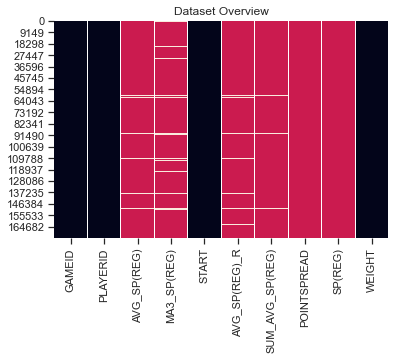

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 6.889000000000001


In [18]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID'] + regressors + [y] + [w]]

helpers.visualize_dataframe(feature_matrix)

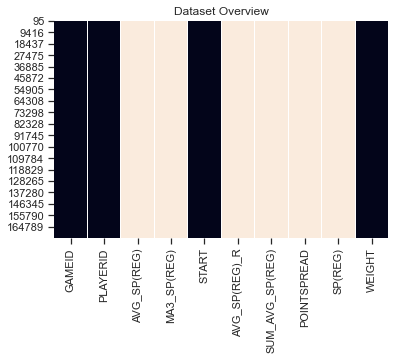

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [19]:
feature_matrix = feature_matrix.dropna(subset=['AVG_SP(REG)'])
feature_matrix['MA3_SP(REG)'] = feature_matrix['MA3_SP(REG)'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['AVG_SP(REG)_R'] = feature_matrix['AVG_SP(REG)_R'].fillna(feature_matrix['AVG_SP(REG)'])
feature_matrix['POINTSPREAD'] = feature_matrix['POINTSPREAD'].fillna(0)
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [20]:
selected_features = regressors
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [ ]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 10,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 614.4597938	test: 617.4310223	best: 617.4310223 (0)	total: 84.1ms	remaining: 7m
1:	learn: 609.8748326	test: 612.8116034	best: 612.8116034 (1)	total: 112ms	remaining: 4m 39s
2:	learn: 605.3694105	test: 608.2734509	best: 608.2734509 (2)	total: 142ms	remaining: 3m 57s
3:	learn: 600.8462280	test: 603.7197469	best: 603.7197469 (3)	total: 171ms	remaining: 3m 33s
4:	learn: 596.4193265	test: 599.2505664	best: 599.2505664 (4)	total: 201ms	remaining: 3m 20s
5:	learn: 592.0542839	test: 594.8369828	best: 594.8369828 (5)	total: 228ms	remaining: 3m 10s
6:	learn: 587.7403795	test: 590.4840592	best: 590.4840592 (6)	total: 258ms	remaining: 3m 4s
7:	learn: 583.4726258	test: 586.1822771	best: 586.1822771 (7)	total: 290ms	remaining: 3m 1s
8:	learn: 579.2984084	test: 581.9631702	best: 581.9631702 (8)	total: 321ms	remaining: 2m 58s
9:	learn: 575.1242554	test: 577.7530364	best: 577.7530364 (9)	total: 353ms	remaining: 2m 56s
10:	learn: 571.0161261	test: 573.6101266	best: 573.6101266 (10)	total: 387m

93:	learn: 369.1894995	test: 369.1492316	best: 369.1492316 (93)	total: 2.44s	remaining: 2m 7s
94:	learn: 367.9019690	test: 367.8499607	best: 367.8499607 (94)	total: 2.47s	remaining: 2m 7s
95:	learn: 366.6246854	test: 366.5558144	best: 366.5558144 (95)	total: 2.5s	remaining: 2m 7s
96:	learn: 365.3793480	test: 365.2925153	best: 365.2925153 (96)	total: 2.52s	remaining: 2m 7s
97:	learn: 364.1432771	test: 364.0403080	best: 364.0403080 (97)	total: 2.54s	remaining: 2m 7s
98:	learn: 362.9339501	test: 362.8137287	best: 362.8137287 (98)	total: 2.57s	remaining: 2m 7s
99:	learn: 361.7308036	test: 361.6003017	best: 361.6003017 (99)	total: 2.59s	remaining: 2m 7s
100:	learn: 360.5578330	test: 360.4138899	best: 360.4138899 (100)	total: 2.62s	remaining: 2m 6s
101:	learn: 359.3845585	test: 359.2283857	best: 359.2283857 (101)	total: 2.64s	remaining: 2m 6s
102:	learn: 358.2377286	test: 358.0696933	best: 358.0696933 (102)	total: 2.67s	remaining: 2m 6s
103:	learn: 357.1026112	test: 356.9136897	best: 356.913

181:	learn: 304.0070413	test: 303.0554488	best: 303.0554488 (181)	total: 4.75s	remaining: 2m 5s
182:	learn: 303.6299886	test: 302.6723285	best: 302.6723285 (182)	total: 4.78s	remaining: 2m 5s
183:	learn: 303.2628362	test: 302.3020669	best: 302.3020669 (183)	total: 4.84s	remaining: 2m 6s
184:	learn: 302.8998567	test: 301.9307742	best: 301.9307742 (184)	total: 4.87s	remaining: 2m 6s
185:	learn: 302.5529916	test: 301.5782034	best: 301.5782034 (185)	total: 4.89s	remaining: 2m 6s
186:	learn: 302.1962418	test: 301.2151912	best: 301.2151912 (186)	total: 4.92s	remaining: 2m 6s
187:	learn: 301.8412088	test: 300.8552210	best: 300.8552210 (187)	total: 4.94s	remaining: 2m 6s
188:	learn: 301.4921544	test: 300.5023417	best: 300.5023417 (188)	total: 4.97s	remaining: 2m 6s
189:	learn: 301.1533585	test: 300.1577894	best: 300.1577894 (189)	total: 5s	remaining: 2m 6s
190:	learn: 300.8150655	test: 299.8142369	best: 299.8142369 (190)	total: 5.03s	remaining: 2m 6s
191:	learn: 300.4820490	test: 299.4823321	b

269:	learn: 284.2874348	test: 283.1534272	best: 283.1534272 (269)	total: 7.13s	remaining: 2m 4s
270:	learn: 284.1649624	test: 283.0337534	best: 283.0337534 (270)	total: 7.15s	remaining: 2m 4s
271:	learn: 284.0440410	test: 282.9113493	best: 282.9113493 (271)	total: 7.18s	remaining: 2m 4s
272:	learn: 283.9206078	test: 282.7891252	best: 282.7891252 (272)	total: 7.21s	remaining: 2m 4s
273:	learn: 283.8036753	test: 282.6736012	best: 282.6736012 (273)	total: 7.23s	remaining: 2m 4s
274:	learn: 283.6850146	test: 282.5545532	best: 282.5545532 (274)	total: 7.26s	remaining: 2m 4s
275:	learn: 283.5679840	test: 282.4370750	best: 282.4370750 (275)	total: 7.29s	remaining: 2m 4s
276:	learn: 283.4515615	test: 282.3223766	best: 282.3223766 (276)	total: 7.32s	remaining: 2m 4s
277:	learn: 283.3373418	test: 282.2084978	best: 282.2084978 (277)	total: 7.35s	remaining: 2m 4s
278:	learn: 283.2229517	test: 282.0932539	best: 282.0932539 (278)	total: 7.38s	remaining: 2m 4s
279:	learn: 283.1126645	test: 281.982128

362:	learn: 277.1197750	test: 276.1091965	best: 276.1091965 (362)	total: 9.67s	remaining: 2m 3s
363:	learn: 277.0759291	test: 276.0672399	best: 276.0672399 (363)	total: 9.7s	remaining: 2m 3s
364:	learn: 277.0294712	test: 276.0226431	best: 276.0226431 (364)	total: 9.72s	remaining: 2m 3s
365:	learn: 276.9858866	test: 275.9787438	best: 275.9787438 (365)	total: 9.76s	remaining: 2m 3s
366:	learn: 276.9419269	test: 275.9355984	best: 275.9355984 (366)	total: 9.78s	remaining: 2m 3s
367:	learn: 276.8985302	test: 275.8952530	best: 275.8952530 (367)	total: 9.81s	remaining: 2m 3s
368:	learn: 276.8532089	test: 275.8532264	best: 275.8532264 (368)	total: 9.83s	remaining: 2m 3s
369:	learn: 276.8114694	test: 275.8128147	best: 275.8128147 (369)	total: 9.86s	remaining: 2m 3s
370:	learn: 276.7679616	test: 275.7710998	best: 275.7710998 (370)	total: 9.88s	remaining: 2m 3s
371:	learn: 276.7242030	test: 275.7283955	best: 275.7283955 (371)	total: 9.91s	remaining: 2m 3s
372:	learn: 276.6810140	test: 275.6867595

448:	learn: 274.3940333	test: 273.5851239	best: 273.5851239 (448)	total: 12.3s	remaining: 2m 4s
449:	learn: 274.3698490	test: 273.5637684	best: 273.5637684 (449)	total: 12.3s	remaining: 2m 4s
450:	learn: 274.3521689	test: 273.5467963	best: 273.5467963 (450)	total: 12.3s	remaining: 2m 4s
451:	learn: 274.3305188	test: 273.5267847	best: 273.5267847 (451)	total: 12.4s	remaining: 2m 4s
452:	learn: 274.3098316	test: 273.5093952	best: 273.5093952 (452)	total: 12.4s	remaining: 2m 4s
453:	learn: 274.2895105	test: 273.4910889	best: 273.4910889 (453)	total: 12.4s	remaining: 2m 4s
454:	learn: 274.2677326	test: 273.4723231	best: 273.4723231 (454)	total: 12.5s	remaining: 2m 4s
455:	learn: 274.2493595	test: 273.4552068	best: 273.4552068 (455)	total: 12.5s	remaining: 2m 4s
456:	learn: 274.2280458	test: 273.4369081	best: 273.4369081 (456)	total: 12.6s	remaining: 2m 4s
457:	learn: 274.2074307	test: 273.4190038	best: 273.4190038 (457)	total: 12.6s	remaining: 2m 4s
458:	learn: 274.1885842	test: 273.402751

# Evaluation
Lastly, I will evaluate the final model.

In [ ]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

First, I will visualize the feature importances.

In [ ]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [ ]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_SP(REG)']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

Residual analysis:

In [ ]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [ ]:
stat, p = shapiro(residuals)
print(stat, p)

Residuals are normally distributed and not heteroskedastic.

# Investigation

Let's look at specific situations in which we know injuries should be a factor.

Josh Hart got an uptick in minutes when LeBron James got injured in the 2018-19 season.

In [ ]:
feature_matrix['SP(REG)_HAT'] = model.predict(feature_matrix[selected_features])

In [ ]:
temp = feature_matrix.merge(
    boxscores[['GAMEID', 'PLAYERID', 'DATE', 'NAME', 'SEASON']],
    on=['GAMEID', 'PLAYERID'], how='left'
)

temp = temp.loc[(temp['NAME'] == 'Josh Hart') & (temp['SEASON'] == '2018-19')]
idx = temp.index[-29]

pd.set_option('display.min_rows', 82)
display(temp[['DATE', 'NAME', 'START', 'SP(REG)_HAT', 'SP(REG)', 'AVG_SP(REG)', 'AVG_SP(REG)_R']])
print()
display(temp.loc[[idx]][['DATE', 'NAME', 'START', 'SP(REG)_HAT', 'SP(REG)', 'AVG_SP(REG)', 'AVG_SP(REG)_R']])

explainer = lime_tabular.LimeTabularExplainer(training_data=feature_matrix[selected_features].values, feature_names=selected_features, class_names='Y', mode="regression")

explained = explainer.explain_instance(temp.loc[idx, selected_features].values, model.predict, num_features=10)
explained.as_pyplot_figure()
plt.show()
plt.close()

The model seems to appropriately adjust for the injury.